Dataset Pipeline:-
1. Dataset Fetching
2. Dataset joining to create master dataset
3. Feature engineering and preprocessing of dataframes
4. Training and Testing split
5. Model Training but naive training
6. Model evaluation for its accuracy,precision and recall
7. Feature importane contributing in SDOH
8. Geospatial Visualization


1. DataSet Fetching

In [2]:
import pandas as pd

clinical_df = pd.read_csv('synthetic_clinical_dataset.csv')
sdoh_df = pd.read_csv('synthetic_sdoh_dataset.csv')

# Merge on dtcode11
merged_df = clinical_df.merge(sdoh_df, on='dtcode11', how='left')
print("Merged dataset shape:", merged_df.shape)
print(merged_df.head())

Merged dataset shape: (50000, 21)
   Patient_ID  dtcode11  Age     Sex        BMI  Has_Hypertension  \
0        1001        65   60  Female  17.230417                 0   
1        1002        57   46  Female  31.577828                 0   
2        1003        63   77    Male  18.970624                 1   
3        1004        68   25    Male  20.939634                 0   
4        1005        65   44  Female  25.396729                 0   

   Has_High_Cholesterol  Family_History_Diabetes  Has_Disease     dtname  ...  \
0                     0                        0            0  Champawat  ...   
1                     1                        1            0    Chamoli  ...   
2                     1                        0            0  Bageshwar  ...   
3                     0                        0            0    Hardwar  ...   
4                     0                        0            0  Champawat  ...   

   Pct_Scheduled_Caste  Avg_Household_Income  Pct_Illiterate  Li

In [3]:
# Target variable
y = merged_df['Has_Disease']

# Drop IDs and names for features
X = merged_df.drop(columns=['Has_Disease', 'Patient_ID', 'dtname', 'dtcode11'])

# One-hot encode categorical features
X = pd.get_dummies(X, columns=['Sex'], drop_first=True)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 8854, number of negative: 31146
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 485
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', random_state=42)

Accuracy: 0.7221
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.73      0.80      7787
           1       0.42      0.71      0.53      2213

    accuracy                           0.72     10000
   macro avg       0.66      0.72      0.67     10000
weighted avg       0.79      0.72      0.74     10000



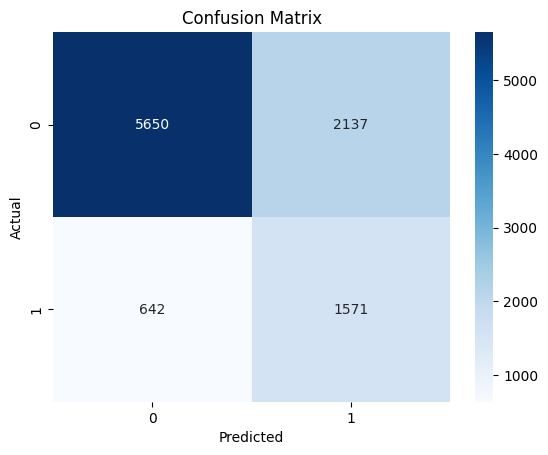

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = lgbm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

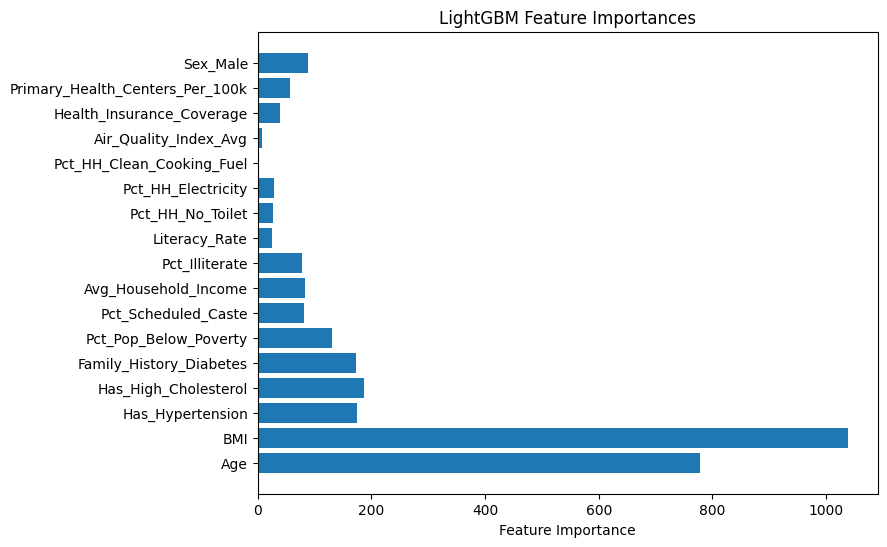

In [7]:
importances = lgbm.feature_importances_
feature_names = X.columns
plt.figure(figsize=(8,6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("LightGBM Feature Importances")
plt.show()

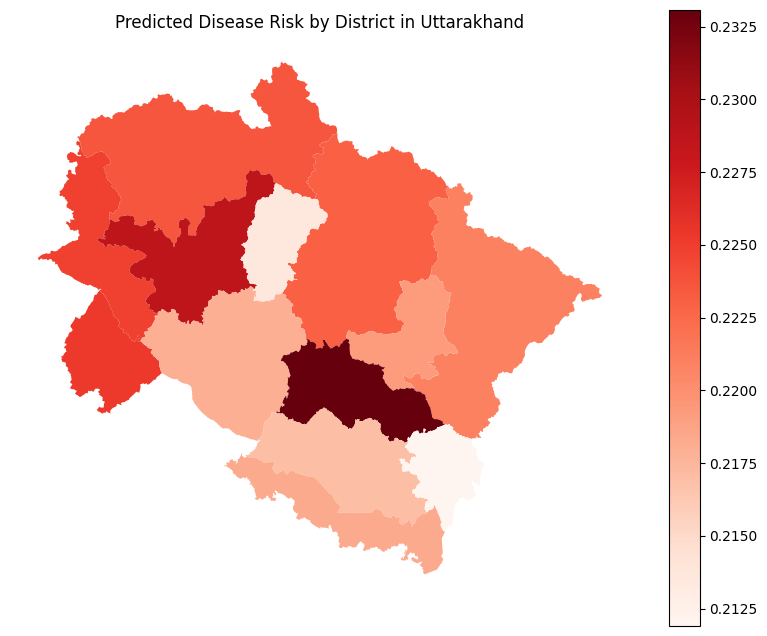

In [9]:
# import geopandas as gpd

# uttarakhand_map = gpd.read_file('UTTARAKHAND_DISTRICTS.geojson')

# # Aggregate predictions by district
# district_risk = merged_df.groupby('dtcode11')['Has_Disease'].mean().reset_index()
# district_risk.columns = ['dtcode11', 'Predicted_Risk']

# # Merge with GeoJSON
# map_with_risk = uttarakhand_map.merge(district_risk, on='dtcode11')

# # Plot choropleth
# map_with_risk.plot(column='Predicted_Risk', cmap='Reds', legend=True, figsize=(10,8))
# plt.title('Predicted Disease Risk by District in Uttarakhand')
# plt.axis('off')
# plt.show()

import geopandas as gpd
import matplotlib.pyplot as plt

# Read the Uttarakhand districts GeoJSON
uttarakhand_map = gpd.read_file('UTTARAKHAND_DISTRICTS.geojson')

# Ensure dtcode11 is integer in both DataFrames
uttarakhand_map['dtcode11'] = uttarakhand_map['dtcode11'].astype(int)
district_risk = merged_df.groupby('dtcode11')['Has_Disease'].mean().reset_index()
district_risk['dtcode11'] = district_risk['dtcode11'].astype(int)
district_risk.columns = ['dtcode11', 'Predicted_Risk']

# Merge with GeoJSON on dtcode11
map_with_risk = uttarakhand_map.merge(district_risk, on='dtcode11')

# Plot choropleth
map_with_risk.plot(column='Predicted_Risk', cmap='Reds', legend=True, figsize=(10,8))
plt.title('Predicted Disease Risk by District in Uttarakhand')
plt.axis('off')
plt.show()

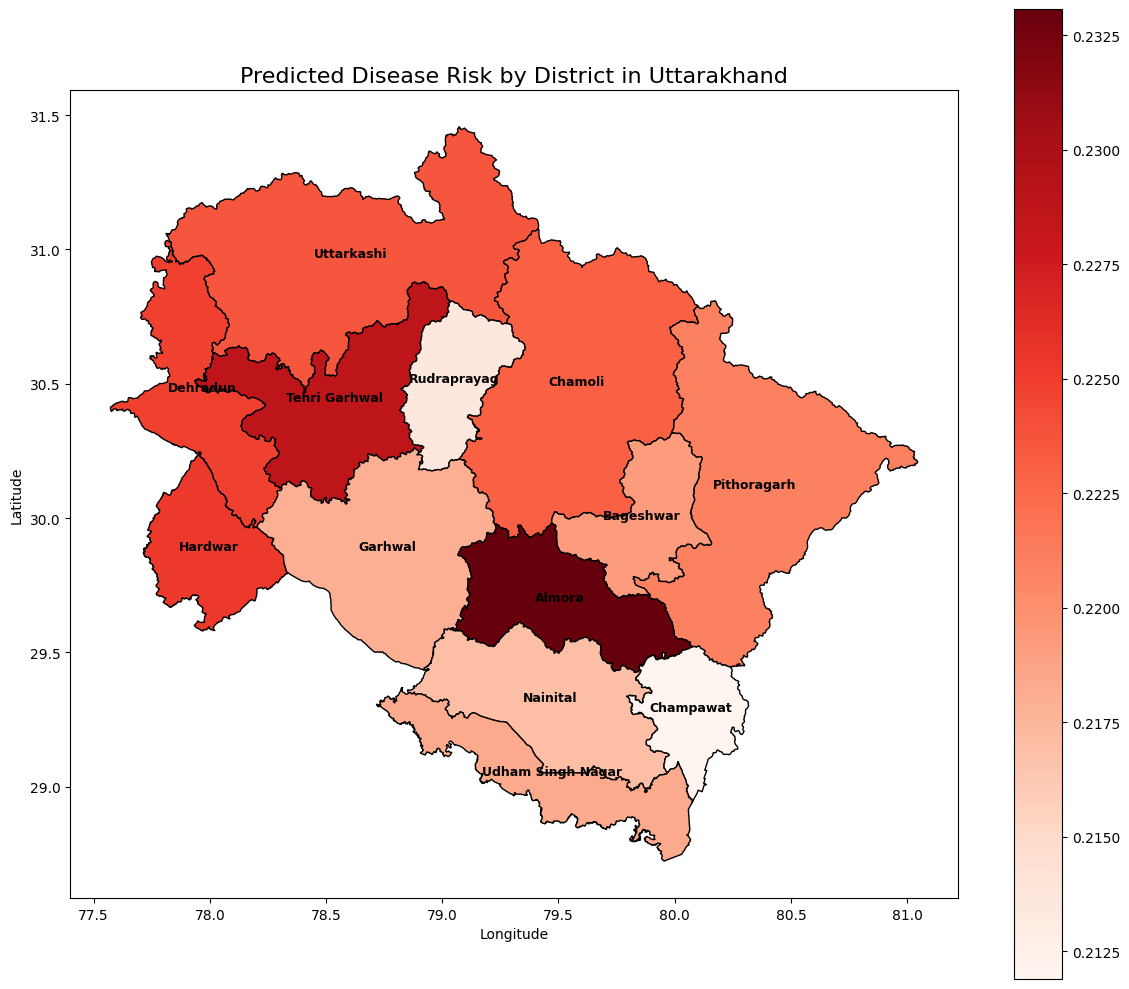

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the Uttarakhand districts GeoJSON
uttarakhand_map = gpd.read_file('UTTARAKHAND_DISTRICTS.geojson')

# Ensure dtcode11 is integer in both DataFrames
uttarakhand_map['dtcode11'] = uttarakhand_map['dtcode11'].astype(int)
district_risk = merged_df.groupby('dtcode11')['Has_Disease'].mean().reset_index()
district_risk['dtcode11'] = district_risk['dtcode11'].astype(int)
district_risk.columns = ['dtcode11', 'Predicted_Risk']

# Merge with GeoJSON on dtcode11
map_with_risk = uttarakhand_map.merge(district_risk, on='dtcode11')

# Plot choropleth with improved labeling
fig, ax = plt.subplots(figsize=(12, 10))
map_with_risk.plot(column='Predicted_Risk', cmap='Reds', legend=True, ax=ax, edgecolor='black')

# Add district names as labels
for idx, row in map_with_risk.iterrows():
    if row['geometry'].centroid.is_empty:
        continue
    plt.annotate(
        text=row['dtname'].strip(),
        xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
        ha='center', fontsize=9, color='black', weight='bold'
    )

plt.title('Predicted Disease Risk by District in Uttarakhand', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()